In [1]:
# filter some warning messages
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import xarray as xr
import pandas as pd

import os
import pickle

In [3]:
datapd = pd.read_csv('all_coord.csv')

In [4]:
import zarr
import gcsfs
# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')

In [14]:
for i in range(0, len(datapd)):
    fname = datapd.at[i, 'source_id'] + '.pickle'
    fpath = 'data_siconc0/' + fname

    if os.path.exists(fpath):
        print('{} exists.'.format(datapd.at[i, 'source_id']))
        continue

    if pd.isna(datapd.at[i,'zstore_siconc']):
        print('{}: no data on google cloud.'.format(datapd.at[i, 'source_id']))
        continue

    ds = xr.open_zarr(gcs.get_mapper(datapd.at[i,'zstore_siconc']), consolidated=True)
    da = ds.siconc

    if 'type' in da.coords:
        da = da.reset_coords('type', drop = True)

    if datapd.at[i, 'source_id'] == 'NESM3':
        da_south = da.where(da.lat < -50, drop=True)
        da_sep = list(da_south.groupby('time.month'))[8][-1]
        da_save = da_sep.load()
        with open(fpath, 'wb') as wf:
            pickle.dump(da_save, wf, pickle.HIGHEST_PROTOCOL)
            print(fname)
        continue

    if datapd.at[i, 'source_id'] == 'GISS-E2-1-H' or datapd.at[i, 'source_id'] == 'GISS-E2-2-H' or datapd.at[i, 'source_id'] == 'NorCPM1':
        southlat = -30
    else:
        southlat = -50
        
    if pd.isna(datapd.at[i, 'latname']):
        if pd.isna(datapd.at[i, 'xname']):
            print("{} doesn't have regular grid.".format(datapd.at[i, 'source_id']))
            continue
        else:
            da_south = da.sel({datapd.at[i, 'yname']:slice(-90, southlat)})
    else:
        da_south = da.where(da[datapd.at[i, 'latname']] < southlat, drop=True)

    da_sep = list(da_south.groupby('time.month'))[8][-1]
    da_save = da_sep.load()
    with open(fpath, 'wb') as wf:
        pickle.dump(da_save, wf, pickle.HIGHEST_PROTOCOL)
    print(fname)

BCC-CSM2-MR exists.
BCC-ESM1 exists.
CAMS-CSM1-0 exists.
ACCESS-ESM1-5 exists.
ACCESS-CM2 exists.
GFDL-CM4 exists.
GFDL-ESM4 exists.
NESM3 exists.
CanESM5 exists.
CanESM5-1: no data on google cloud.
CanESM5-CanOE exists.
CMCC-CM2-SR5 exists.
CMCC-ESM2 exists.
EC-Earth3 exists.
EC-Earth3-CC exists.
EC-Earth3-LR exists.
EC-Earth3-Veg exists.
EC-Earth3-Veg-LR exists.
CNRM-CM6-1 exists.
CNRM-CM6-1-HR exists.
CNRM-ESM2-1 exists.
HadGEM3-GC31-LL exists.
HadGEM3-GC31-MM exists.
UKESM1-0-LL exists.
IPSL-CM5A2-INCA exists.
IPSL-CM6A-LR exists.
MIROC6 exists.
MIROC-ES2L exists.
FGOALS-g3 exists.
CIESM exists.
TaiESM1 exists.
CESM2 exists.
CESM2-FV2 exists.
CESM2-WACCM exists.
CESM2-WACCM-FV2 exists.
SAM0-UNICON exists.
GISS-E2-1-H exists.
GISS-E2-2-H exists.
INM-CM4-8 exists.
INM-CM5-0 exists.
MPI-ESM-1-2-HAM exists.
NorESM1-F exists.
NorESM2-MM exists.
NorCPM1.pickle
MRI-ESM2-0 exists.
MPI-ESM1-2-HR exists.
MPI-ESM1-2-LR exists.
ICON-ESM-LR doesn't have regular grid.
AWI-ESM-1-1-LR doesn't have

In [14]:
datapath = "data_siconc0/"
files = [f for f in os.listdir(datapath)]

In [5]:
path_data = '/mnt/c/Users/shunzi/Documents/Penn/Research/CMIP6/DATA'

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors
import matplotlib.path as mpath
import cmocean
import seaborn as sns

In [6]:
from scipy import ndimage
from skimage import measure
from skimage.segmentation import flood_fill

In [7]:
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [8]:
def newxy_fmissingxy(dx, dy):
    newx0 = dx[~np.isnan(dx).any(axis=1)][0]
    newy0 = dy[:, ~np.isnan(dy).any(axis=0)][:,0]
    newx, newy = np.meshgrid(newx0, newy0)
    return newx, newy

In [9]:
def detect_polynya(dasic, criteria, a):
    s = ndimage.generate_binary_structure(2,2)
    da = dasic <= criteria
    da_masked = xr.DataArray(np.nan*np.empty_like(dasic), dims = dasic.dims, coords = dasic.coords)
    for year in da.time:
        sic = da.sel(time = year)
        sic = xr.where(np.isnan(dasic.sel(time = year)), True, sic) # get rid of "coastal polynya"
        labeled_image, _ = ndimage.label(sic, structure = s)
        region_props = measure.regionprops(labeled_image)
        polygons = []
        for props in region_props:
            if props.area > a:  # the area of ose 'polynya' within the sea ice extent is small
                continue
            polygons.append(props)
        mask = np.zeros_like(labeled_image)
        for props in polygons:
            coords = props.coords
            for coord in coords:         
                mask[coord[0], coord[1]] = 1
        da_masked.loc[year] = xr.where(mask, dasic.sel(time = year), np.nan)
    return da_masked.mean('time'), da_masked.count('time'),

In [34]:
for f in os.listdir(path_data):
    if f != 'E3SM-2-0':
        continue
    new_path = path_data + '/' + f
    fpath = 'data_polynya/' + f + '.pickle'

    ncfs = new_path + "/siconc*.nc"
    ds = xr.open_mfdataset(ncfs)
    da = ds.siconc
    
    if 'type' in da.coords:
        da = da.reset_coords('type', drop = True)

    southlat = -50

    if pd.isna(datapd.loc[datapd['source_id'] == f].iloc[0]['latname']):
        if pd.isna(datapd.loc[datapd['source_id'] == f].iloc[0]['xname']):
            print("{} doesn't have regular grid.".format(f))
            continue
        else:
            da_south = da.sel({datapd.loc[datapd['source_id'] == f].iloc[0]['yname']: slice(-90, southlat)})
            # da_south = da_sigma0.where(da_sigma0[datapd.at[i, 'xname']]< -50, drop=True)
            pltx0 = da_south[datapd.loc[datapd['source_id'] == f].iloc[0]['xname']]
            plty0 = da_south[datapd.loc[datapd['source_id'] == f].iloc[0]['yname']]
            pltx, plty = np.meshgrid(pltx0, plty0)
    else:
        da_south = da.where(da[datapd.loc[datapd['source_id'] == f].iloc[0]['latname']] < southlat, drop=True)
        pltx = da_south[datapd.loc[datapd['source_id'] == f].iloc[0]['lonname']].load()
        plty = da_south[datapd.loc[datapd['source_id'] == f].iloc[0]['latname']].load()
    
    if len(np.shape(pltx)) > 2:
        pltx = pltx.isel(time = 0)
        plty = plty.isel(time = 0)

    da_sep = list(da_south.groupby('time.month'))[8][-1]
    pltdata = da_sep.load()
    
    pltd = pltdata.max('time')

    if f == 'E3SM-2-0':
        pltd = pltd.fillna(0)
        pltd = flood_fill(pltd.values, (0, 0), 100)

    if np.shape(pltd)[1] <= 360: # the grid size
        a = 200  #if < 360, the area > 360 will not be considered as polynya
    else:
        a = np.shape(pltd)[1]*5

    pltd_p, pltd_pcount = detect_polynya(pltdata, 30, a)
    pltd_pc = pltd_pcount.where(pltd_pcount>0)/len(pltdata.time)
    pltd_dict = {'pltd':pltd, 'pld_pc':pltd_pc,'pltx':pltx, 'plty':plty}

    with open(fpath, 'wb') as sf:
        pickle.dump(pltd_dict, sf, pickle.HIGHEST_PROTOCOL)


In [15]:
for j in range(0, len(datapd)):
    rfpath = 'data_siconc0/' + datapd.at[j, 'source_id'] + '.pickle'
    pltd_name = 'data_polynya/' + datapd.at[j, 'source_id'] + '.pickle'
    if os.path.exists(pltd_name):
        print('{} exists.'.format(datapd.at[j, 'source_id']))
        continue
    if os.path.exists(rfpath):
        with open(rfpath, 'rb') as f:
            pltdata = pickle.load(f)
            
        pltd = pltdata.max('time')
        if datapd.at[j, 'source_id'] == 'NESM3':
            pltx = pltdata['lon']
            plty = pltdata['lat']
        else:
            if pd.isna(datapd.at[j, 'latname']):
                pltx0 = pltdata[datapd.at[j, 'xname']]
                plty0 = pltdata[datapd.at[j, 'yname']]
                pltx, plty = np.meshgrid(pltx0, plty0)
            else:
                pltx = pltdata[datapd.at[j, 'lonname']]
                plty = pltdata[datapd.at[j, 'latname']]
        
        # fig = plt.figure(figsize=(12,6))
        #     ax = plt.axes(projection=ccrs.SouthPolarStereo())
        #     ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree());

        if len(np.shape(pltx)) > 2:
            pltx = pltx.isel(time = 0)
            plty = plty.isel(time = 0)
            
        if datapd.at[j, 'source_id'] == "FIO-ESM-2-0" or datapd.at[j, 'source_id'] == "NorESM2-MM" or datapd.at[j, 'source_id'] == "CIESM":
            pltx, plty = newxy_fmissingxy(pltx, plty)
        elif datapd.at[j, 'source_id'] == "GISS-E2-2-H" or datapd.at[j, 'source_id'] == "GISS-E2-1-H" or datapd.at[j, 'source_id'] == "INM-CM4-8":
            pltd = flood_fill(pltd.values, (0, 0), 100)

        if np.shape(pltd)[1] <= 360: # the grid size
            a = 200  #if < 360, the area > 360 will not be considered as polynya
        else:
            a = np.shape(pltd)[1]*5

        pltd_p, pltd_pcount = detect_polynya(pltdata, 30, a)
        pltd_pc = pltd_pcount.where(pltd_pcount>0)/len(pltdata.time)

        pltd_dict = {'pltd':pltd, 'pld_pc':pltd_pc,'pltx':pltx, 'plty':plty}

            # gl = ax.gridlines(
            #     xlocs = np.arange(-180,180,30), 
            #     ylocs = np.arange(-90,90,20),
            #     draw_labels=True, y_inline=True)
                
            # im = ax.pcolormesh(pltx, plty, pltd, 
            #                    transform=ccrs.PlateCarree(), 
            #                    vmin=0, vmax=100, 
            #                    cmap=plt.cm.Greys_r)
            # im2 = ax.pcolormesh(pltx, plty, pltd_pc, transform=ccrs.PlateCarree())

            # ax.add_feature(cfeature.LAND, zorder=1, color='0.8');
            # ax.add_feature(cfeature.COASTLINE, linewidth=1);
            # ax.set_boundary(circle, transform=ax.transAxes);
            # cbar = plt.colorbar(im) 
            # cbar2 = plt.colorbar(im2)
            
        
        with open(pltd_name, 'wb') as sf:
            pickle.dump(pltd_dict, sf, pickle.HIGHEST_PROTOCOL)
            print(pltd_name)
            # with open(pltd_pname, 'wb') as f:
            #     pickle.dump(pltd_p, f, pickle.HIGHEST_PROTOCOL)
            # with open(pltd_pcname, 'wb') as f:
            #     pickle.dump(pltd_pc, f, pickle.HIGHEST_PROTOCOL)

    #         fig.savefig('fig_siconc_test3/{}.{}.png'.format(datapd.at[i, 'source_id'], datapd.at[i, 'grid_label']))
    # print(fname)


BCC-CSM2-MR exists.
BCC-ESM1 exists.
CAMS-CSM1-0 exists.
ACCESS-ESM1-5 exists.
ACCESS-CM2 exists.
GFDL-CM4 exists.
GFDL-ESM4 exists.
NESM3 exists.
CanESM5 exists.
CanESM5-CanOE exists.
CMCC-CM2-SR5 exists.
CMCC-ESM2 exists.
EC-Earth3 exists.
EC-Earth3-CC exists.
EC-Earth3-LR exists.
EC-Earth3-Veg exists.
EC-Earth3-Veg-LR exists.
CNRM-CM6-1 exists.
CNRM-CM6-1-HR exists.
CNRM-ESM2-1 exists.
HadGEM3-GC31-LL exists.
HadGEM3-GC31-MM exists.
UKESM1-0-LL exists.
IPSL-CM5A2-INCA exists.
IPSL-CM6A-LR exists.
MIROC6 exists.
MIROC-ES2L exists.
FGOALS-g3 exists.
CIESM exists.
TaiESM1 exists.
CESM2 exists.
CESM2-FV2 exists.
CESM2-WACCM exists.
CESM2-WACCM-FV2 exists.
SAM0-UNICON exists.
GISS-E2-1-H exists.
GISS-E2-2-H exists.
INM-CM4-8 exists.
INM-CM5-0 exists.
MPI-ESM-1-2-HAM exists.
NorESM1-F exists.
NorESM2-MM exists.
data_polynya/NorCPM1.pickle
MRI-ESM2-0 exists.
MPI-ESM1-2-HR exists.
MPI-ESM1-2-LR exists.
E3SM-1-0 exists.
E3SM-1-1 exists.
E3SM-1-1-ECA exists.


In [12]:
plt.ioff()

for i in range(0, len(datapd)):
    if i > 3:
        break
    fname = datapd.at[i, 'source_id'] + '.' + datapd.at[i, 'grid_label'] + '.nc'
    fpath = 'data_siconc/' + fname
    if os.path.exists(fpath):
        with xr.open_dataset(fpath) as ds:
            pltdata = ds.siconc
            pltd = pltdata.max('time')

            if pd.isna(datapd.at[i, 'latname']):
                if pd.isna(datapd.at[i, 'xname']):
                    print(i, fname)
                    continue
                else:
                    pltx0 = pltdata[datapd.at[i, 'xname']]
                    plty0 = pltdata[datapd.at[i, 'yname']]
                    pltx, plty = np.meshgrid(pltx0, plty0)
            else:
                pltx = pltdata[datapd.at[i, 'lonname']]
                plty = pltdata[datapd.at[i, 'latname']]
            fig = plt.figure(figsize=(12,6))
            ax = plt.axes(projection=ccrs.SouthPolarStereo())
            ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree());

            if len(np.shape(pltx)) > 2:
                pltx = pltx.isel(time = 0)
                plty = plty.isel(time = 0)
            
            if fname == "FIO-ESM-2-0.gn.nc" or fname == "NorESM2-MM.gn.nc" or fname == "CIESM.gn.nc":
                pltx, plty = newxy_fmissingxy(pltx, plty)
            elif fname == "GISS-E2-2-H.gr.nc" or fname == "GISS-E2-1-H.gr.nc" or fname == "INM-CM4-8.gr1.nc":
                pltd = flood_fill(pltd.values, (0, 0), 100)

            if np.shape(pltd)[1] <= 360: # the grid size
                a = 200  #if < 360, the area > 360 will not be considered as polynya
            else:
                a = np.shape(pltd)[1]*5

            pltd_p, pltd_pcount = detect_polynya(pltdata, 30, a)
            pltd_pc = pltd_pcount.where(pltd_pcount>0)/len(pltdata.time)

            gl = ax.gridlines(
                xlocs = np.arange(-180,180,30), 
                ylocs = np.arange(-90,90,20),
                draw_labels=True, y_inline=True)
                
            im = ax.pcolormesh(pltx, plty, pltd, 
                               transform=ccrs.PlateCarree(), 
                               vmin=0, vmax=100, 
                               cmap=plt.cm.Greys_r)
            im2 = ax.pcolormesh(pltx, plty, pltd_pc, transform=ccrs.PlateCarree())

            ax.add_feature(cfeature.LAND, zorder=1, color='0.8');
            ax.add_feature(cfeature.COASTLINE, linewidth=1);
            ax.set_boundary(circle, transform=ax.transAxes);
            cbar = plt.colorbar(im) 
            cbar2 = plt.colorbar(im2)
            
            pltd_name = 'pdata/' + datapd.at[i, 'source_id'] + '.pickle'
            pltd_pname = 'pdata/' + datapd.at[i, 'source_id'] + '_p.pickle'
            pltd_pcname = 'pdata/'+ datapd.at[i, 'source_id'] + '_pc.plckle'
            with open(pltd_name, 'wb') as f:
                pickle.dump(pltd, f, pickle.HIGHEST_PROTOCOL)
            with open(pltd_pname, 'wb') as f:
                pickle.dump(pltd_p, f, pickle.HIGHEST_PROTOCOL)
            with open(pltd_pcname, 'wb') as f:
                pickle.dump(pltd_pc, f, pickle.HIGHEST_PROTOCOL)

            fig.savefig('fig_siconc_test3/{}.{}.png'.format(datapd.at[i, 'source_id'], datapd.at[i, 'grid_label']))
    print(fname)


GFDL-CM4.gn.nc
GFDL-ESM4.gn.nc
CNRM-CM6-1.gn.nc
CNRM-ESM2-1.gn.nc


In [10]:
fname

'CNRM-CM6-1.gn.nc'

In [15]:
plt.ion()

In [9]:
fig = plt.figure(figsize=(8,10))
n = 1

for i in range(0, len(datapd)):
    fname = datapd.at[i, 'source_id'] + '.' + datapd.at[i, 'grid_label'] + '.nc'
    fpath = 'data_siconc/' + fname
    if os.path.exists(fpath):
        with xr.open_dataset(fpath) as ds:
            pltdata = ds.siconc
            pltd = pltdata.max('time')

            if pd.isna(datapd.at[i, 'latname']):
                if pd.isna(datapd.at[i, 'xname']):
                    print(i, fname)
                    continue
                else:
                    pltx0 = pltdata[datapd.at[i, 'xname']]
                    plty0 = pltdata[datapd.at[i, 'yname']]
                    pltx, plty = np.meshgrid(pltx0, plty0)
            else:
                pltx = pltdata[datapd.at[i, 'lonname']]
                plty = pltdata[datapd.at[i, 'latname']]

            if len(np.shape(pltx)) > 2:
                pltx = pltx.isel(time = 0)
                plty = plty.isel(time = 0)
            
            if fname == "FIO-ESM-2-0.gn.nc" or fname == "NorESM2-MM.gn.nc" or fname == "CIESM.gn.nc":
                pltx, plty = newxy_fmissingxy(pltx, plty)
            elif fname == "GISS-E2-2-H.gr.nc" or fname == "GISS-E2-1-H.gr.nc" or fname == "INM-CM4-8.gr1.nc":
                pltd = flood_fill(pltd.values, (0, 0), 100)

            if np.shape(pltd)[1] <= 360: # the grid size
                a = 200  #if < 360, the area > 360 will not be considered as polynya
            else:
                a = np.shape(pltd)[1]*5

            pltd_p, pltd_pcount = detect_polynya(pltdata, 30, a)
            pltd_pc = pltd_pcount.where(pltd_pcount>0)/len(pltdata.time)

            ax = fig.add_subplot(9, 6, n, projection=ccrs.SouthPolarStereo())
            ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

            gl = ax.gridlines(
                xlocs = np.arange(-180,180,30), 
                ylocs = np.arange(-90,90,20),
                draw_labels=False, y_inline=True)
            
            ax.set_title('{}-{}'.format(datapd.at[i, 'source_id'], datapd.at[i, 'grid_label']))
                
            im = ax.pcolormesh(pltx, plty, pltd, 
                               transform=ccrs.PlateCarree(), 
                               vmin=0, vmax=100, 
                               cmap=plt.cm.Greys_r)
            im2 = ax.pcolormesh(pltx, plty, pltd_pc, transform=ccrs.PlateCarree())

            ax.add_feature(cfeature.LAND, zorder=1, color='0.8')
            ax.add_feature(cfeature.COASTLINE, linewidth=1)
            ax.set_boundary(circle, transform=ax.transAxes)
            n = n+1
    
            # cbar = plt.colorbar(im) 
            # cbar2 = plt.colorbar(im2)
    #         fig.savefig('fig_siconc_test2/{}.{}.png'.format(datapd.at[i, 'source_id'], datapd.at[i, 'grid_label']))


NameError: name 'detect_polynya' is not defined

<Figure size 800x1000 with 0 Axes>

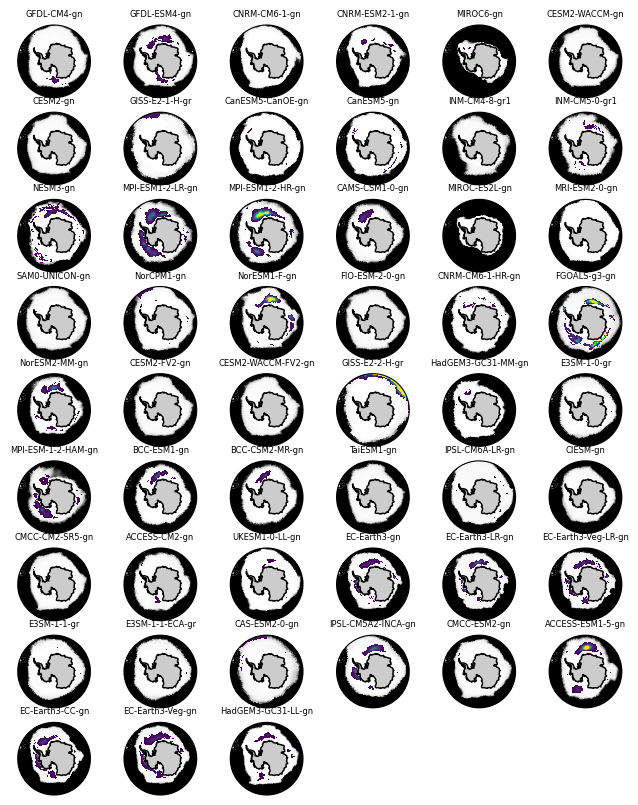

In [16]:
fig = plt.figure(figsize=(8,10))
n = 1

for i in range(0, len(datapd)):
    pltd_name = 'pdata/' + datapd.at[i, 'source_id'] + '.pickle'
    pltd_pname = 'pdata/' + datapd.at[i, 'source_id'] + '_p.pickle'
    pltd_pcname = 'pdata/'+ datapd.at[i, 'source_id'] + '_pc.plckle'

    fname = datapd.at[i, 'source_id'] + '.' + datapd.at[i, 'grid_label'] + '.nc'
    fpath = 'data_siconc/' + fname

    if os.path.exists(pltd_name):
        with open(pltd_name, 'rb') as f:
            pltd = pickle.load(f)
        with open(pltd_pname, 'rb') as f:
            pltd_p =  pickle.load(f)
        with open(pltd_pcname, 'rb') as f:
            pltd_pc =pickle.load(f)

        with xr.open_dataset(fpath) as ds:
            pltdata = ds.siconc

        if pd.isna(datapd.at[i, 'latname']):
            if pd.isna(datapd.at[i, 'xname']):
                print(i, fname)
                continue
            else:
                pltx0 = pltdata[datapd.at[i, 'xname']]
                plty0 = pltdata[datapd.at[i, 'yname']]
                pltx, plty = np.meshgrid(pltx0, plty0)
        else:
            pltx = pltdata[datapd.at[i, 'lonname']]
            plty = pltdata[datapd.at[i, 'latname']]

        if len(np.shape(pltx)) > 2:
            pltx = pltx.isel(time = 0)
            plty = plty.isel(time = 0)
            
        if fname == "FIO-ESM-2-0.gn.nc" or fname == "NorESM2-MM.gn.nc" or fname == "CIESM.gn.nc":
            pltx, plty = newxy_fmissingxy(pltx, plty)

        ax = fig.add_subplot(9, 6, n, projection=ccrs.SouthPolarStereo())
        ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
        
        # gl = ax.gridlines(
        #     xlocs = np.arange(-180,180,90), 
        #     ylocs = np.arange(-90,90,20),
        #     draw_labels=False, y_inline=True)
            
        ax.set_title('{}-{}'.format(datapd.at[i, 'source_id'], datapd.at[i, 'grid_label']), 
                     fontsize=6)
                
        im = ax.pcolormesh(pltx, plty, pltd, 
                           transform=ccrs.PlateCarree(), 
                           vmin=0, vmax=100, 
                           cmap=plt.cm.Greys_r)
        
        im2 = ax.pcolormesh(pltx, plty, pltd_pc, 
                            transform=ccrs.PlateCarree(), 
                            vmin = 0, vmax = 0.2)
        ax.add_feature(cfeature.LAND, zorder=1, color='0.8')
        ax.add_feature(cfeature.COASTLINE, linewidth=1)
        ax.set_boundary(circle, transform=ax.transAxes)
        
        n = n+1
    # fig.colorbar(im)
    # fig.colorbar(im2)
    #         fig.savefig('fig_siconc_test2/{}.{}.png'.format(datapd.at[i, 'source_id'], datapd.at[i, 'grid_label']))


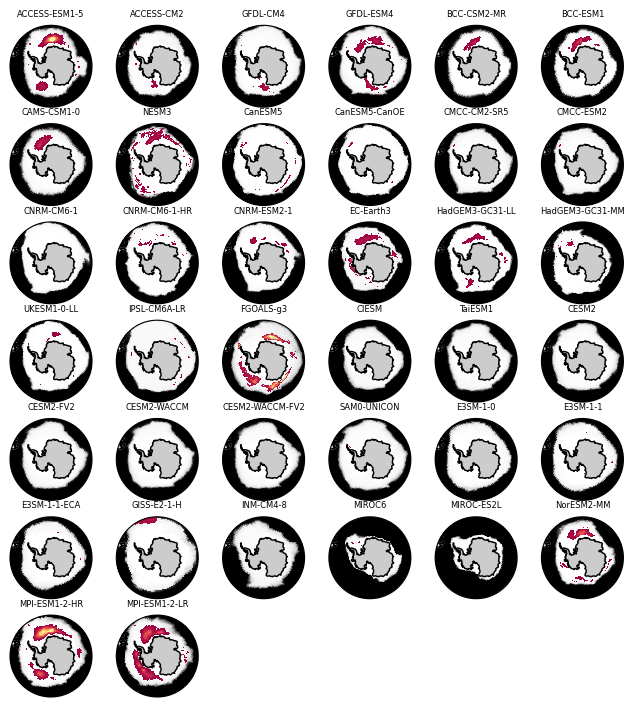

In [14]:
fig = plt.figure(figsize=(8,10))
n = 1

for i in range(0, len(datapd)):
    pltd_name = 'pdata/' + datapd.at[i, 'source_id'] + '.pickle'
    pltd_pname = 'pdata/' + datapd.at[i, 'source_id'] + '_p.pickle'
    pltd_pcname = 'pdata/'+ datapd.at[i, 'source_id'] + '_pc.plckle'

    fname = datapd.at[i, 'source_id'] + '.' + datapd.at[i, 'grid_label'] + '.nc'
    fpath = 'data_siconc/' + fname

    fpathst = 'data_mld2000/' + datapd.at[i, 'source_id'] + '.' + datapd.at[i, 'grid_label'] + '.pickle'

    if os.path.exists(pltd_name):
        if not os.path.exists(fpathst):
            continue

        with open(pltd_name, 'rb') as f:
            pltd = pickle.load(f)
        with open(pltd_pname, 'rb') as f:
            pltd_p =  pickle.load(f)
        with open(pltd_pcname, 'rb') as f:
            pltd_pc =pickle.load(f)

        with xr.open_dataset(fpath) as ds:
            pltdata = ds.siconc

        if pd.isna(datapd.at[i, 'latname']):
            if pd.isna(datapd.at[i, 'xname']):
                print(i, fname)
                continue
            else:
                pltx0 = pltdata[datapd.at[i, 'xname']]
                plty0 = pltdata[datapd.at[i, 'yname']]
                pltx, plty = np.meshgrid(pltx0, plty0)
        else:
            pltx = pltdata[datapd.at[i, 'lonname']]
            plty = pltdata[datapd.at[i, 'latname']]

        if len(np.shape(pltx)) > 2:
            pltx = pltx.isel(time = 0)
            plty = plty.isel(time = 0)
            
        if fname == "FIO-ESM-2-0.gn.nc" or fname == "NorESM2-MM.gn.nc" or fname == "CIESM.gn.nc":
            pltx, plty = newxy_fmissingxy(pltx, plty)

        ax = fig.add_subplot(8, 6, n, projection=ccrs.SouthPolarStereo())
        ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
        
        # gl = ax.gridlines(
        #     xlocs = np.arange(-180,180,90), 
        #     ylocs = np.arange(-90,90,20),
        #     draw_labels=False, y_inline=True)
            
        ax.set_title('{}'.format(datapd.at[i, 'source_id']), fontsize=6)
                
        im = ax.pcolormesh(pltx, plty, pltd, 
                           transform=ccrs.PlateCarree(), 
                           vmin=0, vmax=100, 
                           cmap=plt.cm.Greys_r)
        
        im2 = ax.pcolormesh(pltx, plty, pltd_pc, 
                            transform=ccrs.PlateCarree(), 
                            vmin = 0, vmax = 0.5, cmap=plt.cm.Spectral)
        ax.add_feature(cfeature.LAND, zorder=1, color='0.8')
        ax.add_feature(cfeature.COASTLINE, linewidth=1)
        ax.set_boundary(circle, transform=ax.transAxes)
        
        n = n+1
    # fig.colorbar(im)
    # fig.colorbar(im2)
    #         fig.savefig('fig_siconc_test2/{}.{}.png'.format(datapd.at[i, 'source_id'], datapd.at[i, 'grid_label']))


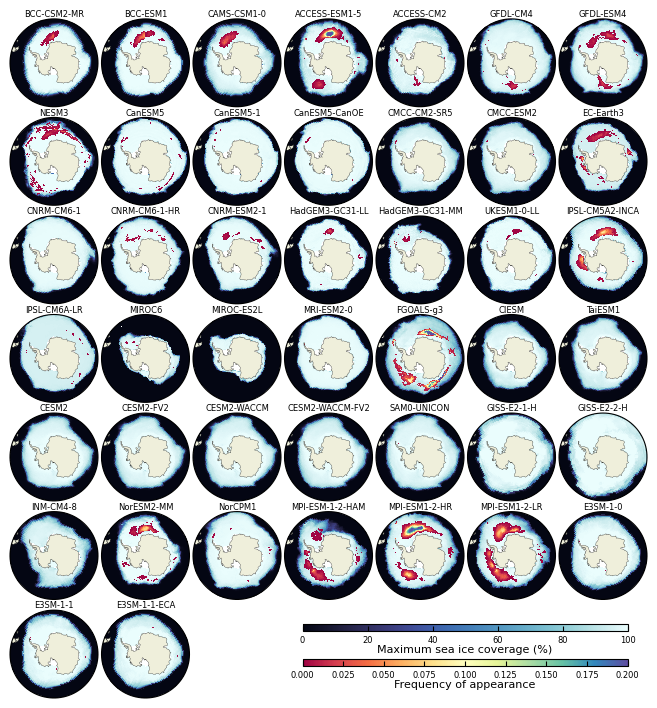

In [7]:
fig = plt.figure(figsize=(6.5,7))

n = 1

# newcmap = cmocean.tools.crop_by_percent(cmocean.cm.matter, 20, which='min', N=None)
for i in range(0, len(datapd)):
    # pltd_dict = {'pltd':pltd, 'pld_pc':pltd_pc,'pltx':pltx, 'plty':plty}

    pltd_name = 'data_polynya/' + datapd.at[i, 'source_id'] + '.pickle'

    fpathst = 'data_mld/' + datapd.at[i, 'source_id'] + '.pickle'

    if os.path.exists(pltd_name):
        if not os.path.exists(fpathst):
            continue

        with open(pltd_name, 'rb') as f:
            pltd_dict = pickle.load(f)
        
        ax = fig.add_subplot(7, 7, n, projection=ccrs.SouthPolarStereo())
        plt.subplots_adjust(left=0.01,
                            bottom=0.01, 
                            right=0.99, 
                            top=0.99, 
                            wspace=0.04, 
                            hspace=0.04)
        # fig.subplots_adjust(wspace=0.04, hspace=0.12)
        ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

        pltx = pltd_dict['pltx']
        plty = pltd_dict['plty']
        pltd = pltd_dict['pltd']
        pltd_pc = pltd_dict['pld_pc']

        # gl = ax.gridlines(
        #     xlocs = np.arange(-180,180,90), 
        #     ylocs = np.arange(-90,90,20),
        #     draw_labels=False, y_inline=True)
            
        ax.set_title('{}'.format(datapd.at[i, 'source_id']), fontsize=6, pad=-0.5)
        
                
        im = ax.pcolormesh(pltx, plty, pltd, 
                           transform=ccrs.PlateCarree(), 
                           vmin=0, vmax=100, 
                           cmap=cmocean.cm.ice)
        
        # newcmap = cmocean.tools.crop_by_percent(cmocean.cm.speed_r, 50, which='min', N=None)
        im2 = ax.pcolormesh(pltx, plty, pltd_pc, 
                            transform=ccrs.PlateCarree(), 
                            vmin = 0, vmax = 0.20, cmap=plt.cm.Spectral)
        ax.add_feature(cfeature.LAND, zorder=1)#, color='0.8')
        ax.add_feature(cfeature.COASTLINE, linewidth=0.2)
        ax.set_boundary(circle, transform=ax.transAxes)
        
        n = n+1       

        # if n > 3:
        #     break 


cbar_ax1 = fig.add_axes([0.46, 0.11, 0.50, 0.01])
cbar1 = fig.colorbar(im, cax=cbar_ax1, orientation='horizontal')
cbar1.set_label('Maximum sea ice coverage (%)', size=8, labelpad=-0.1)
cbar1.ax.tick_params(labelsize=6,direction='in')

cbar_ax2 = fig.add_axes([0.46, 0.06, 0.50, 0.01])
cbar2 = fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal')
cbar2.set_label('Frequency of appearance', size=8, labelpad=-0.1)
cbar2.ax.tick_params(labelsize=6,direction='in')

fig.savefig('Polynya_Multi.png', dpi = 300)


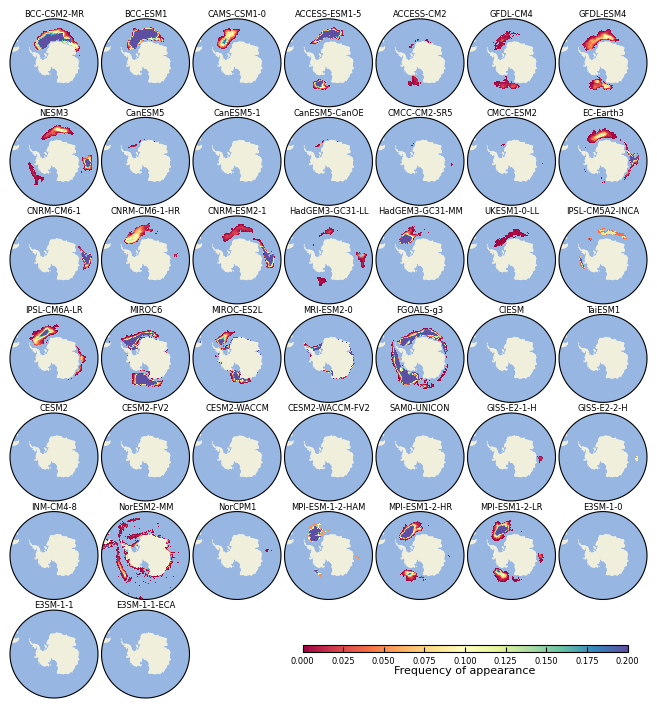

In [8]:
fig = plt.figure(figsize=(6.5,7))

n = 1

# newcmap = cmocean.tools.crop_by_percent(cmocean.cm.matter, 20, which='min', N=None)
for i in range(0, len(datapd)):
    # pltd_dict = {'pltd':pltd, 'pld_pc':pltd_pc,'pltx':pltx, 'plty':plty}

    pltd_name = 'data_polynya/' + datapd.at[i, 'source_id'] + '.pickle'

    fpathst = 'data_mld/' + datapd.at[i, 'source_id'] + '.pickle'

    if os.path.exists(pltd_name):
        if not os.path.exists(fpathst):
            continue

        with open(fpathst, 'rb') as f:
            pltd_dict = pickle.load(f)
        
        ax = fig.add_subplot(7, 7, n, projection=ccrs.SouthPolarStereo())
        plt.subplots_adjust(left=0.01,
                            bottom=0.01, 
                            right=0.99, 
                            top=0.99, 
                            wspace=0.04, 
                            hspace=0.04)
        # fig.subplots_adjust(wspace=0.04, hspace=0.12)
        ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

        pltx = pltd_dict['pltx']
        plty = pltd_dict['plty']

        pltm = xr.where(pltd_dict['mldmax']>=1000, 1, np.nan)
        pltf = pltd_dict['mld2kfq']


        # gl = ax.gridlines(
        #     xlocs = np.arange(-180,180,90), 
        #     ylocs = np.arange(-90,90,20),
        #     draw_labels=False, y_inline=True)
            
        ax.set_title('{}'.format(datapd.at[i, 'source_id']), fontsize=6, pad=-0.5)
        
    
        # im = ax.pcolormesh(pltx, plty, pltm, vmin = 0, vmax=1.2, 
        #                    transform=ccrs.PlateCarree(), cmap=plt.cm.gray)
        ax.add_feature(cfeature.LAND, zorder=1)
        ax.add_feature(cfeature.OCEAN)
        ax.set_boundary(circle, transform=ax.transAxes)
        im2 = ax.pcolormesh(pltx, plty, pltf, vmin = 0, vmax=0.2, 
                           transform=ccrs.PlateCarree(), cmap=plt.cm.Spectral)
        # cbar = plt.colorbar(im) 

        
        # newcmap = cmocean.tools.crop_by_percent(cmocean.cm.speed_r, 50, which='min', N=None)
        # im2 = ax.pcolormesh(pltx, plty, pltd_pc, 
        #                     transform=ccrs.PlateCarree(), 
        #                     vmin = 0, vmax = 0.20, cmap=plt.cm.Spectral)
        # ax.add_feature(cfeature.LAND, zorder=1)#, color='0.8')
        # ax.add_feature(cfeature.COASTLINE, linewidth=0.2)
        # ax.set_boundary(circle, transform=ax.transAxes)
        
        n = n+1       

        # if n > 3:
        #     break 


# cbar_ax1 = fig.add_axes([0.46, 0.11, 0.50, 0.01])
# cbar1 = fig.colorbar(im, cax=cbar_ax1, orientation='horizontal')
# cbar1.set_label('Maximum sea ice coverage (%)', size=8, labelpad=-0.1)
# cbar1.ax.tick_params(labelsize=6,direction='in')

cbar_ax2 = fig.add_axes([0.46, 0.08, 0.50, 0.01])
cbar2 = fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal')
cbar2.set_label('Frequency of appearance', size=8, labelpad=-0.1)
cbar2.ax.tick_params(labelsize=6,direction='in')

fig.savefig('DeepConvection_Multi.png', dpi = 300)


In [10]:
# fig = plt.figure(figsize=(6.5,7))

area_p = []
area_c = []
model_type = []
model_name = []

for i in range(0, len(datapd)):
    pltd_name = 'data_polynya/' + datapd.at[i, 'source_id'] + '.pickle'
    fpathst = 'data_mld/' + datapd.at[i, 'source_id'] + '.pickle'

    if os.path.exists(pltd_name):
        if not os.path.exists(fpathst):
            continue

        with open(fpathst, 'rb') as f:
            pltd_dict = pickle.load(f)

        pltf = pltd_dict['mld2kfq']

        with open(pltd_name, 'rb') as f2:
            pltd_dict2 = pickle.load(f2)
        
        pltd_pc = pltd_dict2['pld_pc']

        path_data_ofx = '/mnt/c/Users/shunzi/Documents/Penn/Research/CMIP6/Ofx/areacello_Ofx_'
        if datapd.at[i, 'source_id'] == 'BCC-CSM2-MR':
            ofx_file = path_data_ofx + "BCC-CSM2-MR_ssp370_r1i1p1f1_gn.nc"
        elif datapd.at[i, 'source_id'] == "BCC-ESM1":
            ofx_file = path_data_ofx + "BCC-ESM1_1pctCO2_r1i1p1f1_gn.nc"
        elif datapd.at[i, 'source_id'] == "CAMS-CSM1-0":
            ofx_file = path_data_ofx + "CAMS-CSM1-0_1pctCO2_r2i1p1f1_gn.nc"
        elif datapd.at[i, 'source_id'] == "FGOALS-g3":
            ofx_file = path_data_ofx + "FGOALS-g3_historical_r1i1p1f1_gn.nc"
        elif datapd.at[i, 'source_id'] == "GISS-E2-2-H":
            ofx_file = path_data_ofx + "GISS-E2-1-H_piControl_" + str(datapd.at[i, 'member_id']) + "_" + str(datapd.at[i, 'grid_label']) + ".nc"
        elif datapd.at[i, 'source_id'] == "E3SM-1-1":
            ofx_file = path_data_ofx + "E3SM-1-1_hist-bgc_r1i1p1f1_gr.nc"    
        elif datapd.at[i, 'source_id'] == "E3SM-1-1-ECA":
            ofx_file = path_data_ofx + "E3SM-1-1-ECA_ssp585-bgc_r1i1p1f1_gr.nc"    
        else:
            ofx_file = path_data_ofx + str(datapd.at[i, 'source_id']) + "_piControl_" + str(datapd.at[i, 'member_id']) + "_" + str(datapd.at[i, 'grid_label']) + ".nc"

        if os.path.exists(ofx_file):
            ds_areacello = xr.open_dataset(ofx_file)
            darea = ds_areacello.areacello.load()
            if datapd.at[i, 'source_id'] in ["CNRM-CM6-1", "CNRM-CM6-1-HR", "CNRM-ESM2-1"]:
                darea = darea.where(darea.lat<-50, drop=True)
            if datapd.at[i, 'source_id'] in ["IPSL-CM5A2-INCA", "IPSL-CM6A-LR"]:
                darea = darea.where(darea.nav_lat<-50, drop=True)
            if datapd.at[i, 'source_id'] == "CIESM":
                darea = darea.where(darea.latitude<-50, drop=True)
                break
            if darea.where(pltd_pc>0).sum()>0:
                if darea.where(pltf>0).sum()>0:
                    print(datapd.at[i, 'source_id'])
                    
                    area_p.append(darea.where(pltd_pc>0).sum().values)
                    area_c.append(darea.where(pltf>0).sum().values)

        else:
            print("{}: no area data.".format(datapd.at[i, 'source_id']))
        # ax.set_title('{}'.format(datapd.at[i, 'source_id']), fontsize=6, pad=-0.5)



BCC-CSM2-MR
BCC-CSM2-MR
BCC-ESM1
BCC-ESM1
CAMS-CSM1-0
CAMS-CSM1-0
ACCESS-ESM1-5
ACCESS-ESM1-5
ACCESS-CM2
ACCESS-CM2
GFDL-CM4
GFDL-CM4
GFDL-ESM4
GFDL-ESM4
NESM3: no area data.
CanESM5
CanESM5
CanESM5-1
CanESM5-CanOE
CanESM5-CanOE
CMCC-CM2-SR5
CMCC-CM2-SR5
CMCC-ESM2
CMCC-ESM2
EC-Earth3
EC-Earth3
CNRM-CM6-1
CNRM-CM6-1-HR
CNRM-CM6-1-HR
CNRM-ESM2-1
CNRM-ESM2-1
HadGEM3-GC31-LL
HadGEM3-GC31-LL
HadGEM3-GC31-MM
HadGEM3-GC31-MM
UKESM1-0-LL
UKESM1-0-LL
IPSL-CM5A2-INCA
IPSL-CM5A2-INCA
IPSL-CM6A-LR
IPSL-CM6A-LR
MIROC6
MIROC6
MIROC-ES2L
MRI-ESM2-0
MRI-ESM2-0
FGOALS-g3
FGOALS-g3
CIESM


: 

In [9]:
darea 

<xarray.DataArray 'areacello' (j: 55, i: 320)>
array([[1.1247860e+09, 1.1246464e+09, 1.1243602e+09, ..., 1.1243602e+09,
        1.1246464e+09, 1.1247860e+09],
       [1.4574505e+09, 1.4574505e+09, 1.4574505e+09, ..., 1.4574505e+09,
        1.4574505e+09, 1.4574505e+09],
       [1.5253078e+09, 1.5253078e+09, 1.5253078e+09, ..., 1.5253078e+09,
        1.5253078e+09, 1.5253078e+09],
       ...,
       [4.6306606e+09, 4.6306606e+09, 4.6306606e+09, ..., 4.6306606e+09,
        4.6306606e+09, 4.6306606e+09],
       [4.6846228e+09, 4.6846228e+09, 4.6846228e+09, ..., 4.6846228e+09,
        4.6846228e+09, 4.6846228e+09],
       [4.7381775e+09, 4.7381775e+09, 4.7381775e+09, ..., 4.7381775e+09,
        4.7381775e+09, 4.7381775e+09]], dtype=float32)
Coordinates:
  * j          (j) int32 1 2 3 4 5 6 7 8 9 10 ... 46 47 48 49 50 51 52 53 54 55
  * i          (i) int32 1 2 3 4 5 6 7 8 9 ... 313 314 315 316 317 318 319 320
    latitude   (j, i) float64 -79.22 -79.22 -79.22 ... -50.37 -50.37 -50.37
    longitude  (j, i) float64 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
Attributes:
    standard_name:  cell_area
    long_name:      Grid-Cell Area for Ocean Variables
    comment:        no feature, CMIP_table_comment: Horizontal area of ocean ...
    units:          m2
    history:        no history
    cell_methods:   area: sum

In [19]:
if darea.where(pltd_pc>0).sum() > 0:
    print("yes")

In [ ]:
fig = plt.figure(figsize=(8,10))
n = 1

for i in range(0, len(datapd)):
    pltd_name = 'pdata/' + datapd.at[i, 'source_id'] + '.pickle'
    pltd_pname = 'pdata/' + datapd.at[i, 'source_id'] + '_p.pickle'
    pltd_pcname = 'pdata/'+ datapd.at[i, 'source_id'] + '_pc.plckle'

    fname = datapd.at[i, 'source_id'] + '.' + datapd.at[i, 'grid_label'] + '.nc'
    fpath = 'data_siconc/' + fname

    fpathst = 'data_mld2000/' + datapd.at[i, 'source_id'] + '.' + datapd.at[i, 'grid_label'] + '.pickle'

    if os.path.exists(pltd_name):
        if not os.path.exists(fpathst):
            continue

        with open(pltd_name, 'rb') as f:
            pltd = pickle.load(f)
        with open(pltd_pname, 'rb') as f:
            pltd_p =  pickle.load(f)
        with open(pltd_pcname, 'rb') as f:
            pltd_pc =pickle.load(f)

        with xr.open_dataset(fpath) as ds:
            pltdata = ds.siconc

        if pd.isna(datapd.at[i, 'latname']):
            if pd.isna(datapd.at[i, 'xname']):
                print(i, fname)
                continue
            else:
                pltx0 = pltdata[datapd.at[i, 'xname']]
                plty0 = pltdata[datapd.at[i, 'yname']]
                pltx, plty = np.meshgrid(pltx0, plty0)
        else:
            pltx = pltdata[datapd.at[i, 'lonname']]
            plty = pltdata[datapd.at[i, 'latname']]

        if len(np.shape(pltx)) > 2:
            pltx = pltx.isel(time = 0)
            plty = plty.isel(time = 0)
            
        if fname == "FIO-ESM-2-0.gn.nc" or fname == "NorESM2-MM.gn.nc" or fname == "CIESM.gn.nc":
            pltx, plty = newxy_fmissingxy(pltx, plty)

        ax = fig.add_subplot(8, 6, n, projection=ccrs.SouthPolarStereo())
        ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
        
        # gl = ax.gridlines(
        #     xlocs = np.arange(-180,180,90), 
        #     ylocs = np.arange(-90,90,20),
        #     draw_labels=False, y_inline=True)
            
        ax.set_title('{}'.format(datapd.at[i, 'source_id']), fontsize=6)
                
        im = ax.pcolormesh(pltx, plty, pltd, 
                           transform=ccrs.PlateCarree(), 
                           vmin=0, vmax=100, 
                           cmap=plt.cm.Greys_r)
        
        im2 = ax.pcolormesh(pltx, plty, pltd_pc, 
                            transform=ccrs.PlateCarree(), 
                            vmin = 0, vmax = 0.5, cmap=plt.cm.Spectral)
        ax.add_feature(cfeature.LAND, zorder=1, color='0.8')
        ax.add_feature(cfeature.COASTLINE, linewidth=1)
        ax.set_boundary(circle, transform=ax.transAxes)
        
        n = n+1
    # fig.colorbar(im)
    # fig.colorbar(im2)
    #         fig.savefig('fig_siconc_test2/{}.{}.png'.format(datapd.at[i, 'source_id'], datapd.at[i, 'grid_label']))


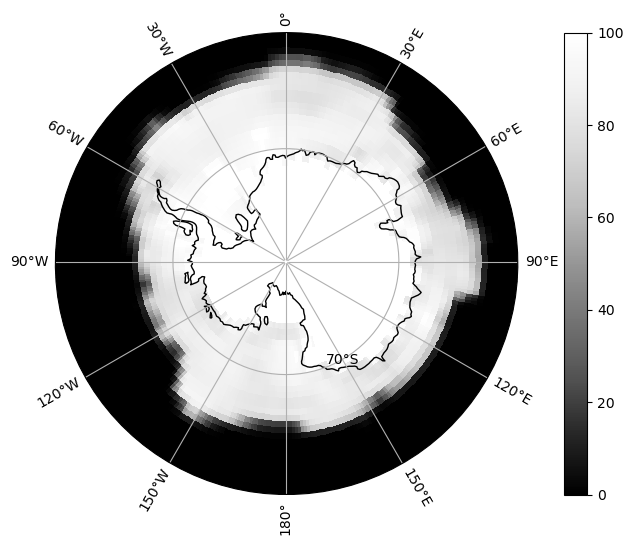

In [37]:
plt.ion()

for i in [9]:
    fname = datapd.at[i, 'source_id'] + '.' + datapd.at[i, 'grid_label'] + '.nc'
    fpath = 'data_siconc/' + fname
    if os.path.exists(fpath):
        with xr.open_dataset(fpath) as ds:
            pltdata = ds.siconc.isel(time = 0)

            if pd.isna(datapd.at[i, 'latname']):
                if pd.isna(datapd.at[i, 'xname']):
                    print(i, fname)
                    continue
                else:
                    pltx0 = pltdata[datapd.at[i, 'xname']]
                    plty0 = pltdata[datapd.at[i, 'yname']]
                    pltx, plty = np.meshgrid(pltx0, plty0)
            else:
                pltx = pltdata[datapd.at[i, 'lonname']]
                plty = pltdata[datapd.at[i, 'latname']]


            fig = plt.figure(figsize=(12,6))
            ax = plt.axes(projection=ccrs.SouthPolarStereo())
            ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree());
            
            gl = ax.gridlines(
                xlocs = np.arange(-180,180,30), 
                ylocs = np.arange(-90,90,20),
                draw_labels=True, y_inline=True)
            # pltdata = pltdata.fillna(100)

            pltdata = flood_fill(pltdata.values, (0, 0), 100)

            try:
                im = ax.pcolormesh(pltx, plty, pltdata, 
                                   transform=ccrs.PlateCarree(), 
                                   vmin=0, vmax=100, 
                                   cmap=plt.cm.Greys_r)
                # ax.add_feature(cfeature.LAND, zorder=1, color='0.8');
                ax.add_feature(cfeature.COASTLINE, linewidth=1);
                ax.set_boundary(circle, transform=ax.transAxes);
                cbar = plt.colorbar(im) 
                # fig.savefig('fig_siconc_test/{}.{}.png'.format(datapd.at[i, 'source_id'], datapd.at[i, 'grid_label']));
            except Exception as E:
                print(i, fname) 
                print(E)


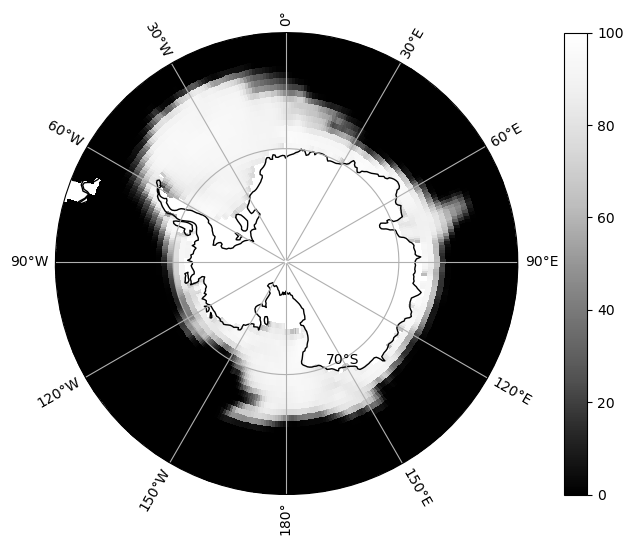

In [30]:
plt.ion()

for i in [12]:
    fname = datapd.at[i, 'source_id'] + '.' + datapd.at[i, 'grid_label'] + '.nc'
    fpath = 'data_siconc/' + fname
    if os.path.exists(fpath):
        with xr.open_dataset(fpath) as ds:
            pltdata = ds.siconc.isel(time = 0)

            if pd.isna(datapd.at[i, 'latname']):
                if pd.isna(datapd.at[i, 'xname']):
                    print(i, fname)
                    continue
                else:
                    pltx0 = pltdata[datapd.at[i, 'xname']]
                    plty0 = pltdata[datapd.at[i, 'yname']]
                    pltx, plty = np.meshgrid(pltx0, plty0)
            else:
                pltx = pltdata[datapd.at[i, 'lonname']]
                plty = pltdata[datapd.at[i, 'latname']]


            fig = plt.figure(figsize=(12,6))
            ax = plt.axes(projection=ccrs.SouthPolarStereo())
            ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree());
            
            gl = ax.gridlines(
                xlocs = np.arange(-180,180,30), 
                ylocs = np.arange(-90,90,20),
                draw_labels=True, y_inline=True)
            # pltdata = pltdata.fillna(100)

            pltdata = flood_fill(pltdata.values, (0, 0), 100, tolerance = 1)

            try:
                im = ax.pcolormesh(pltx, plty, pltdata, 
                                   transform=ccrs.PlateCarree(), 
                                   vmin=0, vmax=100, 
                                   cmap=plt.cm.Greys_r)
                # ax.add_feature(cfeature.LAND, zorder=1, color='0.8');
                ax.add_feature(cfeature.COASTLINE, linewidth=1);
                ax.set_boundary(circle, transform=ax.transAxes);
                cbar = plt.colorbar(im) 
                # fig.savefig('fig_siconc_test/{}.{}.png'.format(datapd.at[i, 'source_id'], datapd.at[i, 'grid_label']));
            except Exception as E:
                print(i, fname) 
                print(E)


In [31]:
fname

'INM-CM4-8.gr1.nc'

In [16]:
pltdata

<xarray.DataArray 'siconc' (lat: 40, lon: 360)>
array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       ...,
       [47.5057  , 47.296524, 47.35906 , ..., 50.271374, 49.187355, 48.814384],
       [ 9.695005,  9.652308,  9.665068, ..., 10.259521, 10.038259,  9.96213 ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ]],
      dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -88.5 -87.5 -86.5 ... -53.5 -52.5 -51.5 -50.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
    time     object 2000-09-16 00:00:00
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Area fraction of grid cell covered by sea ice
    history:        2021-02-21T12:37:17Z altered by CMOR: Treated scalar dime...
    long_name:      Sea Ice Area Fraction (Ocean Grid)
    standard_name:  sea_ice_area_fraction
    units:          %
    coordinates:    type

In [24]:
inds = np.isnan(pltx)

In [51]:
def find_nonanx(dx):
    for i in range(0, np.shape(dx)[0]):
        if ~np.isnan(dx[i,:]).any():
            break
    return dx[i,:]

def find_nonany(dy):
    for i in range(0, np.shape(dy)[1]):
        if ~np.isnan(dy[:,i]).any():
            break
    return dy[:,i]


In [55]:
plty

<xarray.DataArray 'latitude' (nj: 55, ni: 320)>
array([[-79.22052 , -79.22052 , -79.22052 , ...,        nan,        nan,
               nan],
       [-78.68631 , -78.68631 , -78.68631 , ...,        nan,        nan,
               nan],
       [-78.15209 , -78.15209 , -78.15209 , ...,        nan,        nan,
               nan],
       ...,
       [-51.44088 , -51.44088 , -51.44088 , ..., -51.44088 , -51.44088 ,
        -51.44088 ],
       [-50.906647, -50.906647, -50.906647, ..., -50.906647, -50.906647,
        -50.906647],
       [-50.37241 , -50.37241 , -50.37241 , ..., -50.37241 , -50.37241 ,
        -50.37241 ]], dtype=float32)
Coordinates:
    latitude     (nj, ni) float32 -79.22 -79.22 -79.22 ... -50.37 -50.37 -50.37
    longitude    (nj, ni) float32 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    time         object 0001-09-15 12:00:00
    time_bounds  object ...
Dimensions without coordinates: nj, ni
Attributes:
    bounds:         vertices_latitude
    long_name:      latitude
    standard_name:  latitude
    units:          degrees_north

In [57]:
np.unique(pltx, axis=0)

array([[320.5625, 321.6875, 322.8125, ..., 317.1875, 318.3125, 319.4375],
       [320.5625, 321.6875, 322.8125, ..., 317.1875, 318.3125, 319.4375],
       [320.5625, 321.6875, 322.8125, ..., 317.1875, 318.3125, 319.4375],
       ...,
       [320.5625, 321.6875, 322.8125, ...,      nan,      nan,      nan],
       [320.5625, 321.6875, 322.8125, ...,      nan,      nan,      nan],
       [320.5625, 321.6875, 322.8125, ...,      nan,      nan,      nan]],
      dtype=float32)

In [54]:
find_nonany(plty)

<xarray.DataArray 'latitude' (nj: 55)>
array([-79.22052 , -78.68631 , -78.15209 , -77.617874, -77.08366 , -76.54944 ,
       -76.01522 , -75.481   , -74.946785, -74.41257 , -73.87835 , -73.34413 ,
       -72.80991 , -72.275696, -71.74148 , -71.20726 , -70.673035, -70.13882 ,
       -69.6046  , -69.07037 , -68.536156, -68.00193 , -67.46771 , -66.93349 ,
       -66.39927 , -65.86504 , -65.330826, -64.7966  , -64.262375, -63.72815 ,
       -63.193928, -62.659702, -62.125477, -61.59125 , -61.057022, -60.522797,
       -59.98857 , -59.45434 , -58.920116, -58.385887, -57.851658, -57.31743 ,
       -56.7832  , -56.24897 , -55.71474 , -55.180508, -54.64628 , -54.112045,
       -53.577812, -53.04358 , -52.509346, -51.975113, -51.44088 , -50.906647,
       -50.37241 ], dtype=float32)
Coordinates:
    latitude     (nj) float32 -79.22 -78.69 -78.15 ... -51.44 -50.91 -50.37
    longitude    (nj) float32 320.6 320.6 320.6 320.6 ... 320.6 320.6 320.6
    time         object 0001-09-15 12:00:00
    time_bounds  object ...
Dimensions without coordinates: nj
Attributes:
    bounds:         vertices_latitude
    long_name:      latitude
    standard_name:  latitude
    units:          degrees_north

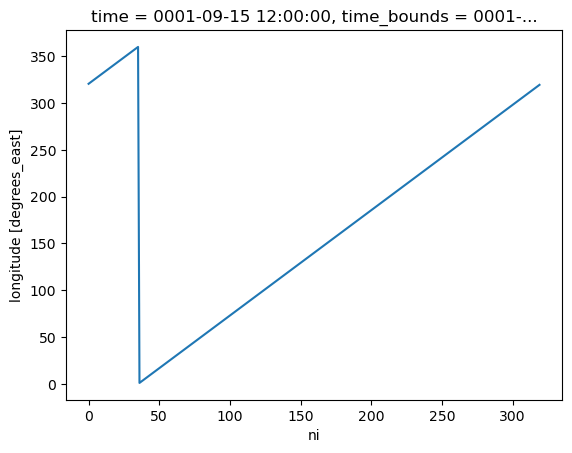

In [53]:
find_nonanx(pltx).plot()

In [ ]:
for i in range(np.shape(dx)[0]):
        if ~np.isnan(pltx[i,:]).any():
            break

In [62]:
plty

<xarray.DataArray 'latitude' (nj: 55, ni: 320)>
array([[-79.22052 , -79.22052 , -79.22052 , ...,        nan,        nan,
               nan],
       [-78.68631 , -78.68631 , -78.68631 , ...,        nan,        nan,
               nan],
       [-78.15209 , -78.15209 , -78.15209 , ...,        nan,        nan,
               nan],
       ...,
       [-51.44088 , -51.44088 , -51.44088 , ..., -51.44088 , -51.44088 ,
        -51.44088 ],
       [-50.906647, -50.906647, -50.906647, ..., -50.906647, -50.906647,
        -50.906647],
       [-50.37241 , -50.37241 , -50.37241 , ..., -50.37241 , -50.37241 ,
        -50.37241 ]], dtype=float32)
Coordinates:
    latitude     (nj, ni) float32 -79.22 -79.22 -79.22 ... -50.37 -50.37 -50.37
    longitude    (nj, ni) float32 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    time         object 0001-09-15 12:00:00
    time_bounds  object ...
Dimensions without coordinates: nj, ni
Attributes:
    bounds:         vertices_latitude
    long_name:      latitude
    standard_name:  latitude
    units:          degrees_north

In [66]:
plty[:, ~np.isnan(plty).any(axis=0)][:,0]

<xarray.DataArray 'latitude' (nj: 55)>
array([-79.22052 , -78.68631 , -78.15209 , -77.617874, -77.08366 , -76.54944 ,
       -76.01522 , -75.481   , -74.946785, -74.41257 , -73.87835 , -73.34413 ,
       -72.80991 , -72.275696, -71.74148 , -71.20726 , -70.673035, -70.13882 ,
       -69.6046  , -69.07037 , -68.536156, -68.00193 , -67.46771 , -66.93349 ,
       -66.39927 , -65.86504 , -65.330826, -64.7966  , -64.262375, -63.72815 ,
       -63.193928, -62.659702, -62.125477, -61.59125 , -61.057022, -60.522797,
       -59.98857 , -59.45434 , -58.920116, -58.385887, -57.851658, -57.31743 ,
       -56.7832  , -56.24897 , -55.71474 , -55.180508, -54.64628 , -54.112045,
       -53.577812, -53.04358 , -52.509346, -51.975113, -51.44088 , -50.906647,
       -50.37241 ], dtype=float32)
Coordinates:
    latitude     (nj) float32 -79.22 -78.69 -78.15 ... -51.44 -50.91 -50.37
    longitude    (nj) float32 320.6 320.6 320.6 320.6 ... 320.6 320.6 320.6
    time         object 0001-09-15 12:00:00
    time_bounds  object ...
Dimensions without coordinates: nj
Attributes:
    bounds:         vertices_latitude
    long_name:      latitude
    standard_name:  latitude
    units:          degrees_north

In [59]:
pltx[~np.isnan(pltx).any(axis=1)][0]

<xarray.DataArray 'longitude' (ni: 320)>
array([320.5625, 321.6875, 322.8125, ..., 317.1875, 318.3125, 319.4375],
      dtype=float32)
Coordinates:
    latitude     (ni) float32 -66.4 -66.4 -66.4 -66.4 ... -66.4 -66.4 -66.4
    longitude    (ni) float32 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    time         object 0001-09-15 12:00:00
    time_bounds  object ...
Dimensions without coordinates: ni
Attributes:
    bounds:         vertices_longitude
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [43]:
np.shape(pltx)[0]

55

In [33]:
pltx[0,:]

<xarray.DataArray 'longitude' (ni: 320)>
array([320.5625, 321.6875, 322.8125, ...,      nan,      nan,      nan],
      dtype=float32)
Coordinates:
    latitude     (ni) float32 -79.22 -79.22 -79.22 -79.22 ... nan nan nan nan
    longitude    (ni) float32 320.6 321.7 322.8 323.9 nan ... nan nan nan nan
    time         object 0001-09-15 12:00:00
    time_bounds  object ...
Dimensions without coordinates: ni
Attributes:
    bounds:         vertices_longitude
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [38]:
np.isnan(pltx[0,:]).any()

<xarray.DataArray 'longitude' ()>
array(True)
Coordinates:
    time         object 0001-09-15 12:00:00
    time_bounds  object ...

In [37]:
if np.isnan(pltx[0,:]).any():
    print("1")
else:
    print("0")

1


In [21]:
pltx

<xarray.DataArray 'longitude' (nj: 55, ni: 320)>
array([[320.5625, 321.6875, 322.8125, ...,      nan,      nan,      nan],
       [320.5625, 321.6875, 322.8125, ...,      nan,      nan,      nan],
       [320.5625, 321.6875, 322.8125, ...,      nan,      nan,      nan],
       ...,
       [320.5625, 321.6875, 322.8125, ..., 317.1875, 318.3125, 319.4375],
       [320.5625, 321.6875, 322.8125, ..., 317.1875, 318.3125, 319.4375],
       [320.5625, 321.6875, 322.8125, ..., 317.1875, 318.3125, 319.4375]],
      dtype=float32)
Coordinates:
    latitude     (nj, ni) float32 -79.22 -79.22 -79.22 ... -50.37 -50.37 -50.37
    longitude    (nj, ni) float32 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    time         object 0001-09-15 12:00:00
    time_bounds  object ...
Dimensions without coordinates: nj, ni
Attributes:
    bounds:         vertices_longitude
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

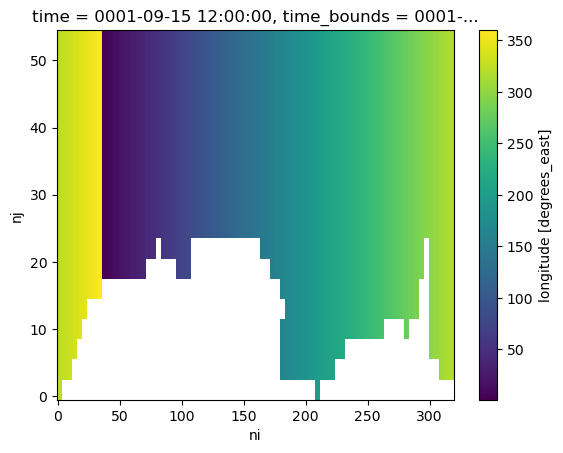

In [22]:
pltx.plot()

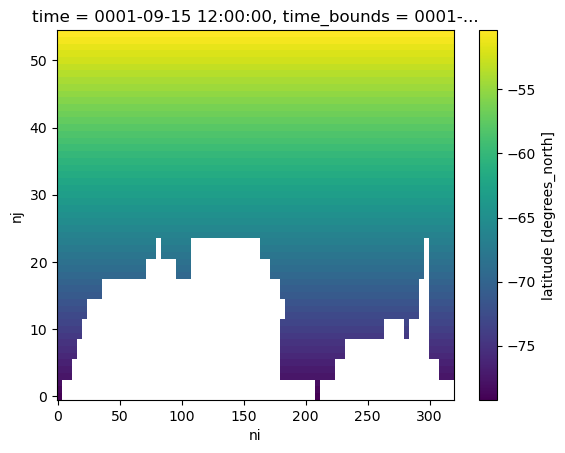

In [23]:
plty.plot()

In [13]:
np.isnan(pltx)

<xarray.DataArray 'longitude' (j: 55, i: 320)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52 53 54
    latitude   (j, i) float64 -79.22 -79.22 -79.22 ... -50.37 -50.37 -50.37
    longitude  (j, i) float64 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    time       object 0301-09-16 00:00:00
Attributes:
    bounds:         vertices_longitude
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [43]:
pltx

<xarray.DataArray 'longitude' (j: 55, i: 320)>
array([[320.5625, 321.6875, 322.8125, ..., 317.1875, 318.3125, 319.4375],
       [320.5625, 321.6875, 322.8125, ..., 317.1875, 318.3125, 319.4375],
       [320.5625, 321.6875, 322.8125, ..., 317.1875, 318.3125, 319.4375],
       ...,
       [320.5625, 321.6875, 322.8125, ..., 317.1875, 318.3125, 319.4375],
       [320.5625, 321.6875, 322.8125, ..., 317.1875, 318.3125, 319.4375],
       [320.5625, 321.6875, 322.8125, ..., 317.1875, 318.3125, 319.4375]])
Coordinates:
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52 53 54
    latitude   (j, i) float64 -79.22 -79.22 -79.22 ... -50.37 -50.37 -50.37
    longitude  (j, i) float64 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    time       object 0301-09-16 00:00:00
Attributes:
    bounds:         vertices_longitude
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [30]:
pltx

<xarray.DataArray 'longitude' (j: 55, i: 320)>
[17600 values with dtype=float64]
Coordinates:
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52 53 54
    latitude   (j, i) float64 ...
    longitude  (j, i) float64 ...
    time       object 0301-09-16 00:00:00
Attributes:
    bounds:         vertices_longitude
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [31]:
plty

<xarray.DataArray 'latitude' (j: 55, i: 320)>
[17600 values with dtype=float64]
Coordinates:
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52 53 54
    latitude   (j, i) float64 ...
    longitude  (j, i) float64 ...
    time       object 0301-09-16 00:00:00
Attributes:
    bounds:         vertices_latitude
    long_name:      latitude
    standard_name:  latitude
    units:          degrees_north

In [23]:
for n in range(0, len(files)):
    newpath = datapath + files[n]
    with xr.open_dataset(newpath) as ds:
        print(files[n])
        print(ds, "\n")
        # if ds.dims['time'] == 2000:
        #     print(files[n])
        # if len(ds.dims) == 3:
        #     print(ds.dims)

CMIP.AS-RCEC.TaiESM1.piControl.SImon.gn.nc
<xarray.Dataset>
Dimensions:    (i: 320, j: 384, time: 100)
Coordinates:
  * i          (i) int32 1 2 3 4 5 6 7 8 9 ... 313 314 315 316 317 318 319 320
  * j          (j) int32 1 2 3 4 5 6 7 8 9 ... 377 378 379 380 381 382 383 384
    latitude   (j, i) float64 ...
    longitude  (j, i) float64 ...
  * time       (time) object 0601-09-16 00:00:00 ... 0700-09-16 00:00:00
    type       |S7 ...
Data variables:
    siconc     (time, j, i) float32 ... 

CMIP.AWI.AWI-ESM-1-1-LR.piControl.SImon.gn.nc
<xarray.Dataset>
Dimensions:  (ncells: 126859, time: 100)
Coordinates:
    lat      (ncells) float64 ...
    lon      (ncells) float64 ...
  * time     (time) datetime64[ns] 1855-09-16 1856-09-16 ... 1954-09-16
Dimensions without coordinates: ncells
Data variables:
    siconc   (time, ncells) float32 ... 

CMIP.BCC.BCC-CSM2-MR.piControl.SImon.gn.nc
<xarray.Dataset>
Dimensions:    (lat: 232, lon: 360, time: 600)
Coordinates:
  * lat        (lat) float64 -

In [19]:
xr.open_dataset("dataset/CMIP.MOHC.HadGEM3-GC31-LL.piControl.SImon.gn.nc")

<xarray.Dataset>
Dimensions:    (i: 360, j: 330, time: 2000)
Coordinates:
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 322 323 324 325 326 327 328 329
    latitude   (j, i) float32 ...
    longitude  (j, i) float32 ...
  * time       (time) object 1850-09-16 00:00:00 ... 3849-09-16 00:00:00
    type       |S7 ...
Data variables:
    siconc     (time, j, i) float32 ...